# Installing the missing package

In [1]:
from google.colab import files
files.upload() #upload kaggle.json
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle (6).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists


# Rquired imports for the project

In [2]:

import ast
from tqdm import tqdm
import warnings; warnings.filterwarnings('ignore')
from IPython.display import display
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras

from skimage import io
from google.colab.patches import cv2_imshow
import cv2

import tensorflow as tf
import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
import random

from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras import models, layers

from sklearn.model_selection import train_test_split
'''
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
'''
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')  

Thu Nov 25 23:28:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Data Loading (takes about 2 min)


In [3]:
# Importing the dataset from Kaggle (If old token already exists, get a new .JSON file after generating new token from kaggle. Also do a "Factory Reset in Colab")
!kaggle datasets download paultimothymooney/breast-histopathology-images

breast-histopathology-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
!pwd
!ls -l
!cd /content
!unzip -o /content/breast-histopathology-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1551_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1601_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1651_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1701_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1751_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1801_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1851_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1901_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1951_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2001_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2251_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2301_class0.png  
  inflating: IDC_regular_

In [5]:
from os import listdir
base_path = "../content"
files = listdir(base_path)
print((files))

['.config', '9260', '13461', '9319', '12893', '12878', '13401', '10304', '15634', '8867', '13689', '13400', '14189', '12821', '16165', '12901', 'kaggle (3).json', '10268', '12820', '12905', '13020', '13462', '9081', '15632', '13022', '16554', '14156', '9178', '15510', '10273', '13617', '15633', '12955', '13666', '9255', 'kaggle (2).json', '12242', '9029', '13106', '9044', '12748', '10285', '9261', '9346', '12810', '15903', '12626', '10278', '12886', '12894', '14082', '10264', '8916', '9078', '10300', '16550', '10293', '16895', '8955', '12892', '12867', '10301', '13459', '10258', '13688', '13916', '12907', '12241', '15473', '9176', '16551', '9173', '13024', '14213', '16085', '10288', '12823', '14154', '13019', '9258', '9037', '14305', '8956', '13687', '16531', '14209', '15515', '15516', '14188', '14079', '12822', '10302', '8865', '12883', '12933', '13613', '12906', '9135', '12826', '9324', '14210', '9043', '9228', '15512', '9174', '12897', '13021', '9226', '14078', '12911', '9265', '165

In [6]:
from glob import glob
data = glob('./IDC_regular_ps50_idx5/**/*.png', recursive=True)

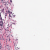

In [7]:
images = data[0]
im = io.imread(images)
image_2 = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
cv2_imshow(image_2)

In [8]:
# Two arrays holding images by class type
class0 = [] # 0 = no cancer
class1 = [] # 1 = cancer

for filename in data:
    if filename.endswith("class0.png"):
         class0.append(filename)
    elif filename.endswith("class1.png"):
        class1.append(filename)

print("Patches without cancer (Class 0) = ", len(class0))
print("Patches containing cancer (Class 1) = ", len(class1))

Patches without cancer (Class 0) =  198738
Patches containing cancer (Class 1) =  78786


**Balancing and Random Sampling**

In [9]:

# Increasing the number of cancer samples to match the size
class2 = []
class2 = class1 + class1 + class1[:41166]
len(class2)

# Randomizing both types of samples
class0_rand = random.sample(class0, len(class0))
class2_rand = random.sample(class2, len(class2))



'\n# Increasing the number of cancer samples to match the size\nclass2 = []\nclass2 = class1 + class1 + class1[:41166]\nlen(class2)\n\n# Randomizing both types of samples\nclass0_rand = random.sample(class0, len(class0))\nclass2_rand = random.sample(class2, len(class2))\n\n'

In [10]:
'''
class0_rand = random.sample(class0, len(class1))
class2_rand = random.sample(class1, len(class1))
'''

**Function to read images and assign labels**

In [11]:
from matplotlib.image import imread
import cv2

def get_image_arrays(data, label):
    img_arrays = []
    for i in data:
        if i.endswith('.png'):
            img = cv2.imread(i ,cv2.IMREAD_COLOR)
            img_sized = cv2.resize(img, (50, 50), interpolation=cv2.INTER_LINEAR)
            img_arrays.append([img_sized, label])
    return img_arrays


**Creating shuffled complete dataset**

In [12]:
# No-Cancer images
class0_array = get_image_arrays(class0_rand, 0)
# Cancer Images
class1_array = get_image_arrays(class2_rand, 1)

In [13]:
res = np.vstack((np.array(class0_array), np.array(class1_array)))
print(res.shape)

(157572, 2)


In [14]:
x = []
y = []
for features,labels in res:
    x.append(features)
    y.append(labels)

x = np.array(x).reshape(-1, 50, 50, 3)

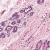

In [15]:
cv2_imshow(x[5])

**Making dataset splits and one-hot encoding y**

In [16]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# Converting y_train and y_test to one-hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(110300, 50, 50, 3) (47272, 50, 50, 3) (110300, 2) (47272, 2)


In [17]:
print(y_test[3])

[1. 0.]


In [27]:
# Needs more RAM
'''
datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
datagen.fit(x_train)
datagen.fit(x_test)
'''

**Building the model (Simple CNN)**

In [28]:
# Simple Model
def Simple_CNN():
  model = Sequential()    
  model.add(Conv2D(64, (3,3), kernel_initializer='he_uniform', padding="same", activation='relu', input_shape=(50,50, 3)))
  model.add(MaxPooling2D(2))
  model.add(BatchNormalization())
  model.add(Conv2D(128, (3,3), kernel_initializer='he_uniform', padding="same", activation='relu'))
  model.add(MaxPooling2D(2))
  model.add(BatchNormalization())
  model.add(Conv2D(256, (3,3), kernel_initializer='he_uniform', padding="same", activation='relu'))
  model.add(MaxPooling2D(2))
  model.add(BatchNormalization())
  model.add(Conv2D(128, (3,3), kernel_initializer='he_uniform', padding="same", activation='relu'))
  model.add(MaxPooling2D(2))
  model.add(Conv2D(64, (3,3), kernel_initializer='he_uniform', padding="same", activation='relu'))
  model.add(MaxPooling2D(2))
  model.add(Flatten())
  model.add(Dense(64, activation = "relu"))
  model.add(Dense(2, activation = "sigmoid"))
  return model

**CNN with Regularization**

In [20]:
def Reg_CNN():
  model = Sequential()    
  model.add(Conv2D(64, (3,3), kernel_initializer='he_uniform', padding="same", kernel_regularizer=regularizers.l2(1), activation='relu', input_shape=(50,50, 3)))
#  model.add(MaxPooling2D(2))
  model.add(BatchNormalization())
  model.add(Conv2D(128, (3,3), kernel_initializer='he_uniform', padding="same", kernel_regularizer=regularizers.l2(1), activation='relu'))
#  model.add(MaxPooling2D(2))
  model.add(BatchNormalization())
  model.add(Conv2D(128, (3,3), kernel_initializer='he_uniform', padding="same", kernel_regularizer=regularizers.l2(1), activation='relu'))
#  model.add(MaxPooling2D(2))
  model.add(BatchNormalization())
  model.add(Conv2D(64, (3,3), kernel_initializer='he_uniform', padding="same", kernel_regularizer=regularizers.l2(1), activation='relu'))
#  model.add(MaxPooling2D(2))
  model.add(Flatten())
  model.add(Dense(32, kernel_regularizer=regularizers.l2(1), activation = "relu"))
  model.add(Dense(2, kernel_regularizer=regularizers.l2(1), activation = "sigmoid"))
  return model

**Model - Imagenet**

In [21]:
def modelEfficientNet():    
    model = models.Sequential()
    model.add(EfficientNetB0(include_top = False, weights = "imagenet", input_shape=(50,50, 3)))
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(2, activation = "sigmoid"))    
    return model 

**Select and fit the desired model**

In [29]:
model = Simple_CNN()
# model = Reg_CNN()
# model = modelEfficientNet()
model.summary()

# opt = tf.optimizers.Adam(learning_rate=0.001)
opt = tf.keras.optimizers.SGD(1e-2, momentum=0.9)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=['AUC'])
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs= 30)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 50, 50, 64)        1792      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 25, 25, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 25, 25, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_6 (Conv2D)           (None, 25, 25, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 12, 12, 128)      0         
 2D)                                                             
                                                      

**Generate Confusion Matrix**

[[7.4060291e-02 9.2583156e-01]
 [5.7724960e-02 9.4234306e-01]
 [9.9999797e-01 2.0786720e-06]
 ...
 [9.9982965e-01 1.7007499e-04]
 [4.6527952e-11 1.0000000e+00]
 [9.9446541e-01 5.4895063e-03]]
[[0. 1.]
 [0. 1.]
 [1. 0.]
 ...
 [1. 0.]
 [0. 1.]
 [1. 0.]]


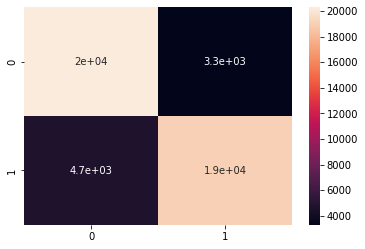

In [23]:
import sklearn
results = model.predict(x_test)
predicted_labels = (results > 0.5).astype(np.float)
print(results)
print(predicted_labels)

sklearn.metrics.precision_recall_fscore_support(y_test, predicted_labels, average='weighted')

confusion_matrix = sklearn.metrics.confusion_matrix(y_test.argmax(axis=1), predicted_labels.argmax(axis=1));

sns.heatmap(confusion_matrix, annot=True)

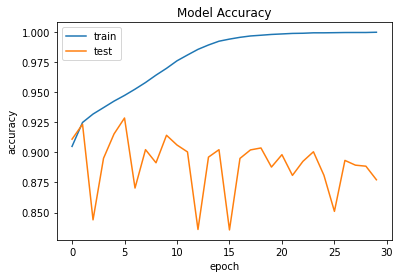

In [30]:
import matplotlib.pyplot as plt
#plotting the Accuracy of test and training sets
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

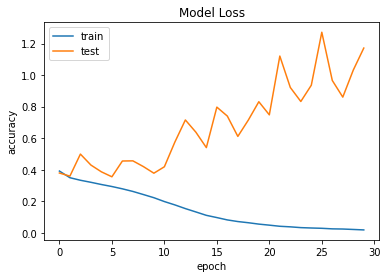

In [31]:
import matplotlib.pyplot as plt
#plotting the Accuracy of test and training sets
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()